# Import Packages

In [1]:
import glob
import os
import gc
import warnings
from matplotlib import style

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_log_error
from hyperopt import fmin, tpe, hp, space_eval

ModuleNotFoundError: No module named 'seaborn'

In [2]:
style.use('dark_background')   # let graphs clear in the dark background of VScode
plt.rcParams['font.sans-serif']=['SimHei']   # Avoid abnormal display of Chineses Lables 
plt.rcParams['axes.unicode_minus'] = False   # Avoid abnormal dsiplay of '-'
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings("ignore")

# Load Data

In [3]:
path = '../input/store-sales-time-series-forecasting/' 

df_hoilday = pd.read_csv(path + 'holidays_events.csv')
df_oil = pd.read_csv(path + 'oil.csv')
df_store = pd.read_csv(path + 'stores.csv')
df_transaction = pd.read_csv(path + 'transactions.csv')

df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

df_name = ['df_hoilday', 'df_oil', 'df_store', 'df_transaction', 'df_train', 'df_test']


# Data Pre-processing

## Real Holiday Celebration Dates

In [4]:
df_hoilday['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [5]:
# Real Holiday Celebration Dates Coding (-1/0/1)
df_hoilday_real = df_hoilday[df_hoilday['transferred'] == False]

df_hoilday_real['hoilday_code'] = 0

for i in range(df_hoilday_real.shape[0]):
    if df_hoilday_real['type'].iloc[i] in ['Holiday', 'Transfer', 'Additional', 'Bridge']:
        df_hoilday_real['hoilday_code'].iloc[i] = 1

df_hoilday_real

,date,type,locale,locale_name,description,transferred,hoilday_code
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,1
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,1
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,1
...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,1
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,1
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,1
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,1


## Four kind of Event Date

In [6]:
df_hoilday[df_hoilday['type']== 'Event'].description.unique()

array(['Dia de la Madre', 'Inauguracion Mundial de futbol Brasil',
       'Mundial de futbol Brasil: Ecuador-Suiza',
       'Mundial de futbol Brasil: Ecuador-Honduras',
       'Mundial de futbol Brasil: Ecuador-Francia',
       'Mundial de futbol Brasil: Octavos de Final',
       'Mundial de futbol Brasil: Cuartos de Final',
       'Mundial de futbol Brasil: Semifinales',
       'Mundial de futbol Brasil: Tercer y cuarto lugar',
       'Mundial de futbol Brasil: Final', 'Black Friday', 'Cyber Monday',
       'Terremoto Manabi', 'Terremoto Manabi+1', 'Terremoto Manabi+2',
       'Terremoto Manabi+3', 'Terremoto Manabi+4', 'Terremoto Manabi+5',
       'Terremoto Manabi+6', 'Terremoto Manabi+7', 'Terremoto Manabi+8',
       'Terremoto Manabi+9', 'Terremoto Manabi+10', 'Terremoto Manabi+11',
       'Terremoto Manabi+12', 'Terremoto Manabi+13',
       'Terremoto Manabi+14', 'Terremoto Manabi+15',
       'Terremoto Manabi+16', 'Terremoto Manabi+17',
       'Terremoto Manabi+18', 'Terremoto 

In [7]:
# Dia de la madre
df_Madre = df_hoilday[df_hoilday['description'] == 'Dia de la Madre']
df_Madre['Madre_code'] = 1

# Mundial de futbol
df_worldcup = df_hoilday[df_hoilday['description'].str.contains('Mundial de futbol', na=False)]
df_worldcup['worldcup_code'] = 1

# Shopping event
df_shopping = df_hoilday[df_hoilday['description'].str.contains('Black Friday|Cyber Monday', regex=True, na=False)]
df_shopping['shopping_code'] = 1

# Terremoto Manabi
df_earthquake = df_hoilday[df_hoilday['description'].str.contains('Terremoto Manabi', na=False)]
list = []
for i in range(df_earthquake.shape[0]):
    list.append(i+1)
df_earthquake['earthquake_day'] = list

## Fill in Oil Prices

In [8]:
if 'date' in df_oil.columns:
    df_oil['date'] = pd.to_datetime(df_oil['date'] , format="%Y-%m-%d")
    df_oil = df_oil.set_index('date').asfreq('D').fillna(method="bfill")
    df_oil.reset_index(inplace=True)
    df_oil['date'] = df_oil['date'].astype(str)
    
df_oil.head(14)

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.20
5,2013-01-06,93.20
6,2013-01-07,93.20
7,2013-01-08,93.21
8,2013-01-09,93.08
9,2013-01-10,93.81


## Merge all of data

In [9]:
df_all = pd.concat([df_train, df_test], axis=0, ignore_index=True)
print(df_all.shape, df_train.shape, df_test.shape)

# store
df_all = df_all.merge(df_store, how='left', on='store_nbr')

# miss 'Santo Domingo de los Tsachilas' &  'Ecuador'
# hoilday
df_hoilday_real.rename(columns={'hoilday_code': 'hoilday_code_local'}, inplace=True)
df_all = df_all.merge(df_hoilday_real[['date', 'locale_name', 'hoilday_code_local']], how='left', left_on=['date','city'], right_on=['date', 'locale_name'])
df_all.drop('locale_name',axis=1, inplace=True)

df_national_hoilday = df_hoilday_real[df_hoilday_real['locale_name']=='Ecuador']
df_national_hoilday.rename(columns={'hoilday_code_local': 'hoilday_code_national'}, inplace=True)
df_all = df_all.merge(df_national_hoilday[['date', 'hoilday_code_national']], how='left', left_on=['date'], right_on=['date'])

# event
df_all = df_all.merge(df_Madre[['date', 'Madre_code']], how='left', left_on=['date'], right_on=['date'])
df_all = df_all.merge(df_worldcup[['date', 'worldcup_code']], how='left', left_on=['date'], right_on=['date'])
df_all = df_all.merge(df_shopping[['date', 'shopping_code']], how='left', left_on=['date'], right_on=['date'])
df_all = df_all.merge(df_earthquake[['date', 'earthquake_day']], how='left', left_on=['date'], right_on=['date'])

# oil
df_all = df_all.merge(df_oil, how='left', left_on=['date'], right_on=['date'])

# # transaction
# df_all = df_all.merge(df_transaction, how='left', left_on=['date','store_nbr'], right_on=['date','store_nbr'])

df_all.drop_duplicates(subset=['id'], keep='last', inplace=True, ignore_index=True)

print(df_all.shape)

(3029400, 6) (3000888, 6) (28512, 5)
(3029400, 17)


# Feature Engineering

## Oil price windows/lag feature

In [10]:
# Window
df_all['avg_oil'] = df_all['dcoilwtico'].rolling(7).mean()

# lag
for l in [1, 10, 31]:
    df_all[f'oil_lags{l}'] = df_all['dcoilwtico'].shift(l)

df_all.fillna(method='bfill', inplace=True)

## Oil price decomposed series feature

In [11]:
def decompse(df):
    df_decomposed = seasonal_decompose(df, model='additive', period = 31, extrapolate_trend=True)
    df_trend = df_decomposed.trend
    df_seasonal = df_decomposed.seasonal
    df_residual = df_decomposed.resid
    return df_trend, df_seasonal, df_residual

df_all['oil_trend'], df_all['oil_seasonal'], df_all['oil_residual'] = decompse(df_all['dcoilwtico'])

## Time Related Features

In [12]:
df_all['date'] = pd.to_datetime(df_all['date'] , format="%Y-%m-%d")

def create_date_features(df):
    df['month'] = df.date.dt.month.astype("int8")
    df['day_of_month'] = df.date.dt.day.astype("int8")
    df['day_of_year'] = df.date.dt.dayofyear.astype("int16")
    df['week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    df['week_of_year'] = (df.date.dt.weekofyear).astype("int8")
    df['day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
    df['year'] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df["quarter"] = df.date.dt.quarter.astype("int8")
    df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
    df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype("int8")
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype("int8")
    df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
    return df
df_all = create_date_features(df_all)

# Workday
df_all["workday"] = np.where((df_all.hoilday_code_local == 1) | (df_all.hoilday_code_national==1) | (df_all['day_of_week'].isin([6,7])), 0, 1)

# Wage day
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')
calendar['wageday']=0
calendar.loc[(calendar.index.to_timestamp().is_month_end) | (calendar.index.day == 15), 'wageday'] = 1
calendar.index = calendar.index.to_series().astype(str)
calendar.reset_index(inplace=True)
calendar.rename(columns={'index':'date'}, inplace=True)
calendar['date'] = pd.to_datetime(calendar['date'] , format="%Y-%m-%d")
df_all = df_all.merge(calendar, how='left', on='date')

# School Season
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')
school_season = []
for i, r in calendar.iterrows():
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else :
        school_season.append(0)
calendar['school_season'] = school_season

calendar.index = calendar.index.to_series().astype(str)
calendar.reset_index(inplace=True)
calendar.rename(columns={'index':'date'}, inplace=True)
calendar['date'] = pd.to_datetime(calendar['date'] , format="%Y-%m-%d")
df_all = df_all.merge(calendar, how='left', on='date')

## 0 Sales Product Family

In [13]:
df_family_0 = df_all.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
df_family_0  = df_family_0 [df_family_0.sales == 0]
df_family_0 ['0_sales'] = 1
df_all = df_all.merge(df_family_0.drop(['sales'], axis=1), how='left', on=['store_nbr', 'family'])

## Product Family Average Sales

In [14]:
# remove those rows before the stores opened
df_sale = df_all[~((df_all.store_nbr == 52) & (df_all.date < "2017-04-20"))]
df_sale = df_sale[~((df_sale.store_nbr == 22) & (df_sale.date < "2015-10-09"))]
df_sale = df_sale[~((df_sale.store_nbr == 42) & (df_sale.date < "2015-08-21"))]
df_sale = df_sale[~((df_sale.store_nbr == 21) & (df_sale.date < "2015-07-24"))]
df_sale = df_sale[~((df_sale.store_nbr == 29) & (df_sale.date < "2015-03-20"))]
df_sale = df_sale[~((df_sale.store_nbr == 20) & (df_sale.date < "2015-02-13"))]
df_sale = df_sale[~((df_sale.store_nbr == 53) & (df_sale.date < "2014-05-29"))]
df_sale = df_sale[~((df_sale.store_nbr == 36) & (df_sale.date < "2013-05-09"))]

df_family = df_sale.groupby(['store_nbr', "family", ]).sales.mean().sort_values(ascending = False).reset_index()
df_family = df_family.rename(columns={'sales': 'avg sales'})
df_all = df_all.merge(df_family, how='left', on=['family', 'store_nbr'])

## Fill NaN value

In [15]:
df_all.fillna(value = 0, inplace=True)
print(df_all.info(null_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3029400 entries, 0 to 3029399
Data columns (total 45 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   id                     3029400 non-null  int64         
 1   date                   3029400 non-null  datetime64[ns]
 2   store_nbr              3029400 non-null  int64         
 3   family                 3029400 non-null  object        
 4   sales                  3029400 non-null  float64       
 5   onpromotion            3029400 non-null  int64         
 6   city                   3029400 non-null  object        
 7   state                  3029400 non-null  object        
 8   type                   3029400 non-null  object        
 9   cluster                3029400 non-null  int64         
 10  hoilday_code_local     3029400 non-null  float64       
 11  hoilday_code_national  3029400 non-null  float64       
 12  Madre_code             30294

# Data Modeling

-------------------------------------------------- AUTOMOTIVE --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.5381435691128595


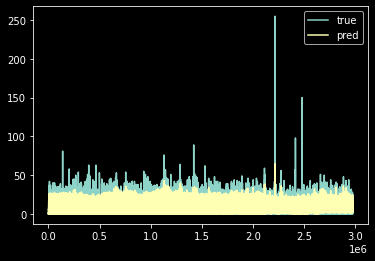

Best RMSLE in Val : 0.5146472448978398
Number of feature : 34
Best number of Interation : 619
['store_nbr', 'dcoilwtico', 'day_of_year', 'avg sales', 'oil_residual', 'day_of_month', 'day_of_week', 'week_of_year', 'year', 'onpromotion', 'oil_seasonal', 'earthquake_day', 'avg_oil', 'month', 'cluster', 'school_season', 'shopping_code', 'season', 'hoilday_code_national', 'is_year_start', 'worldcup_code', 'oil_lags1', 'oil_trend', 'is_month_end', 'Madre_code', 'week_of_month', 'wageday', 'is_wknd', 'is_quarter_end', 'is_quarter_start', 'is_year_end', 'oil_lags10', 'is_month_start', 'quarter']
100%|██████████| 100/100 [08:33<00:00,  5.13s/trial, best loss: 0.5118135037489715]
best_params =  {'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'num_leaves': 38, 'num_round': 1400.0}
RMSLE of validation Data: 0.5118135037489715


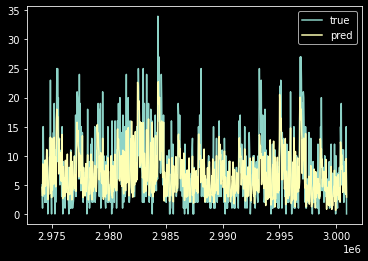

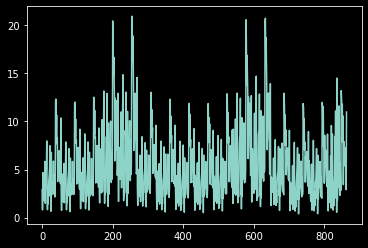

-------------------------------------------------- BABY CARE --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.22192283947590888


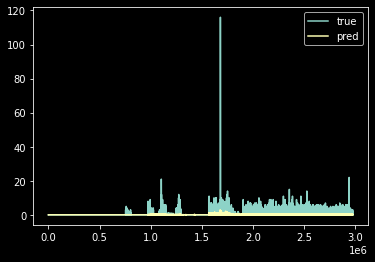

Best RMSLE in Val : 2.0
Number of feature : 1
Best number of Interation : 1000
['store_nbr']
100%|██████████| 100/100 [01:39<00:00,  1.01trial/s, best loss: 0.283875051928118]
best_params =  {'bagging_fraction': 0.8, 'feature_fraction': 0.9, 'num_leaves': 46, 'num_round': 1500.0}
RMSLE of validation Data: 0.283875051928118


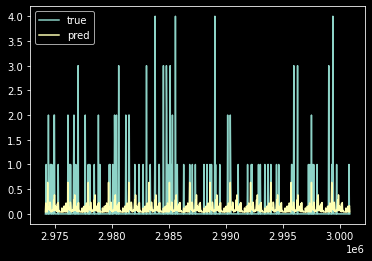

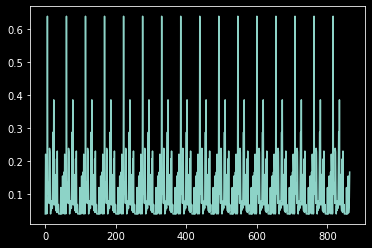

-------------------------------------------------- BEAUTY --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.47750256756656584


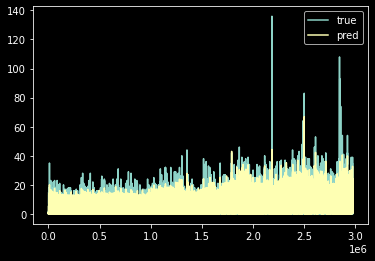

Best RMSLE in Val : 0.4948984687246644
Number of feature : 21
Best number of Interation : 540
['store_nbr', 'day_of_year', 'dcoilwtico', 'avg sales', 'day_of_week', 'day_of_month', 'oil_residual', 'onpromotion', 'earthquake_day', 'week_of_year', 'year', 'oil_seasonal', 'avg_oil', 'month', 'Madre_code', 'shopping_code', 'cluster', 'season', 'worldcup_code', 'is_year_start', 'hoilday_code_national']
100%|██████████| 100/100 [10:09<00:00,  6.09s/trial, best loss: 0.48797288112536996]
best_params =  {'bagging_fraction': 0.9, 'feature_fraction': 1.0, 'num_leaves': 32, 'num_round': 1000.0}
RMSLE of validation Data: 0.48797288112536996


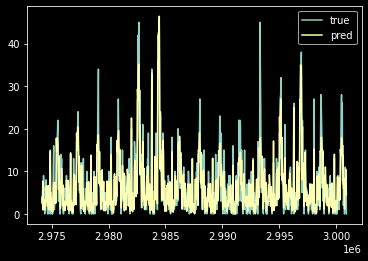

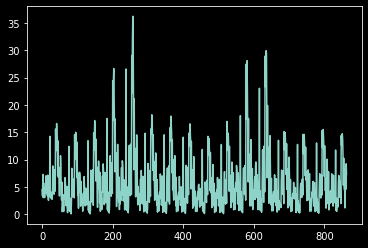

-------------------------------------------------- BEVERAGES --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 1.76638153878694


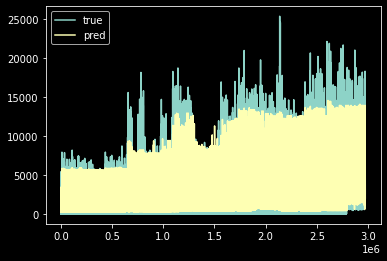

Best RMSLE in Val : 0.35096527311905323
Number of feature : 36
Best number of Interation : 611
['store_nbr', 'day_of_week', 'avg sales', 'year', 'onpromotion', 'day_of_year', 'dcoilwtico', 'month', 'shopping_code', 'day_of_month', 'week_of_year', 'season', 'worldcup_code', 'is_year_start', 'avg_oil', 'cluster', 'school_season', 'earthquake_day', 'is_wknd', 'oil_lags10', 'week_of_month', 'hoilday_code_national', 'oil_trend', 'is_month_end', 'is_year_end', 'Madre_code', 'hoilday_code_local', 'oil_lags31', 'oil_lags1', 'is_month_start', 'oil_seasonal', 'oil_residual', 'workday', '0_sales', 'is_quarter_end', 'is_quarter_start']
100%|██████████| 100/100 [15:07<00:00,  9.08s/trial, best loss: 0.3438469639777642]
best_params =  {'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'num_leaves': 40, 'num_round': 1500.0}
RMSLE of validation Data: 0.3438469639777642


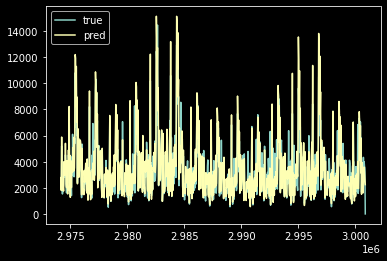

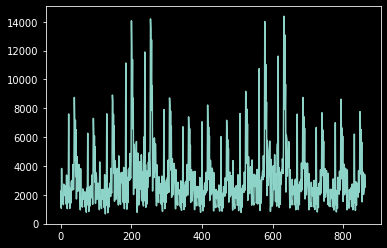

-------------------------------------------------- BOOKS --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.1155476671006713


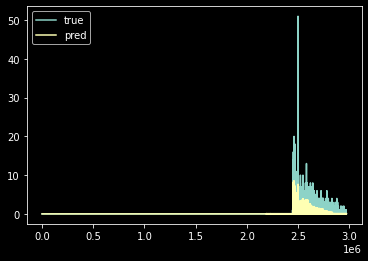

Best RMSLE in Val : 0.07012263438940369
Number of feature : 6
Best number of Interation : 205
['day_of_year', 'avg sales', 'store_nbr', 'week_of_year', 'day_of_month', 'day_of_week']
100%|██████████| 100/100 [01:24<00:00,  1.18trial/s, best loss: 0.06988529413804823]
best_params =  {'bagging_fraction': 1.0, 'feature_fraction': 0.8, 'num_leaves': 38, 'num_round': 800.0}
RMSLE of validation Data: 0.06988529413804823


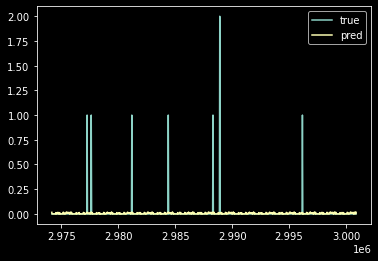

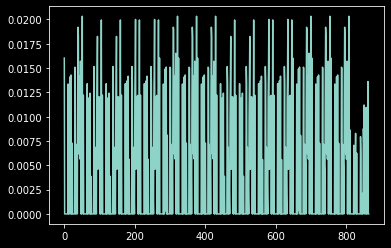

-------------------------------------------------- BREAD/BAKERY --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.7345198617450183


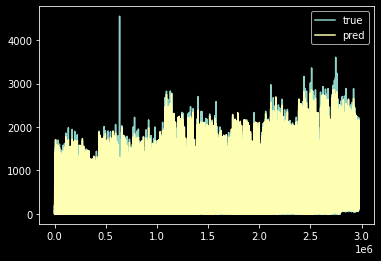

Best RMSLE in Val : 0.283652951916989
Number of feature : 27
Best number of Interation : 920
['store_nbr', 'day_of_year', 'day_of_week', 'avg sales', 'dcoilwtico', 'onpromotion', 'day_of_month', 'week_of_year', 'year', 'oil_residual', 'earthquake_day', 'month', 'worldcup_code', 'avg_oil', 'cluster', 'oil_seasonal', 'season', 'oil_lags10', 'shopping_code', 'hoilday_code_national', 'is_year_start', 'school_season', 'oil_trend', 'Madre_code', 'wageday', 'week_of_month', 'is_month_end']
100%|██████████| 100/100 [20:13<00:00, 12.13s/trial, best loss: 0.2821910550230025]
best_params =  {'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'num_leaves': 32, 'num_round': 1800.0}
RMSLE of validation Data: 0.2821910550230025


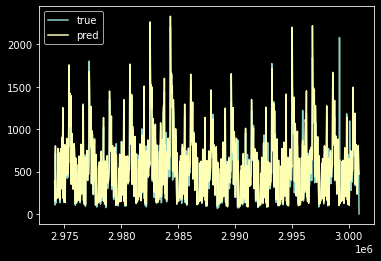

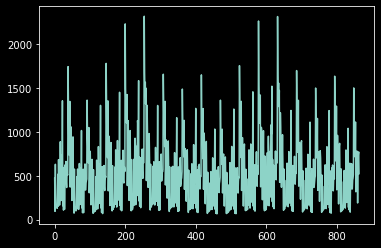

-------------------------------------------------- CELEBRATION --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.9712188479770939


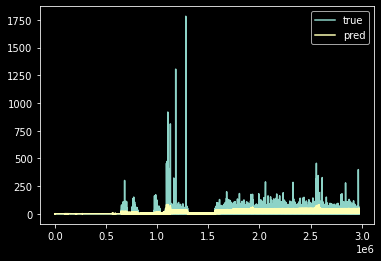

Best RMSLE in Val : 2.0
Number of feature : 1
Best number of Interation : 1000
['year']
100%|██████████| 100/100 [00:52<00:00,  1.91trial/s, best loss: 0.7698337919389577]
best_params =  {'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'num_leaves': 42, 'num_round': 1400.0}
RMSLE of validation Data: 0.7698337919389577


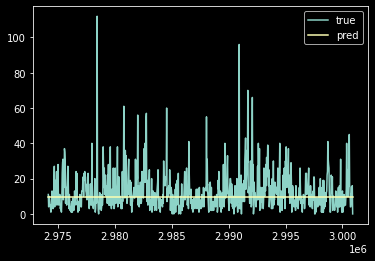

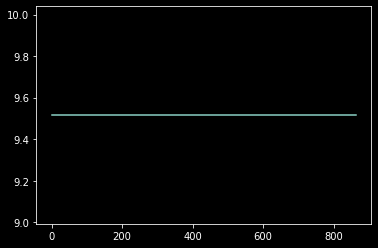

-------------------------------------------------- CLEANING --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 1.521685906047569


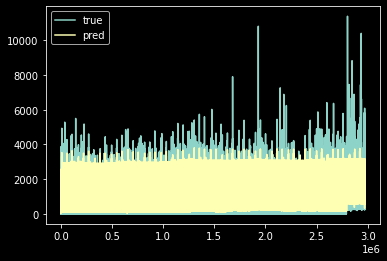

Best RMSLE in Val : 0.33213864534606763
Number of feature : 8
Best number of Interation : 1000
['store_nbr', 'day_of_week', 'day_of_month', 'avg sales', 'day_of_year', 'onpromotion', 'dcoilwtico', 'is_year_start']
100%|██████████| 100/100 [13:56<00:00,  8.37s/trial, best loss: 0.3255622536092948]
best_params =  {'bagging_fraction': 0.9, 'feature_fraction': 1.0, 'num_leaves': 36, 'num_round': 2000.0}
RMSLE of validation Data: 0.3255622536092948


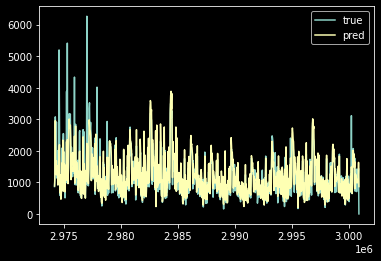

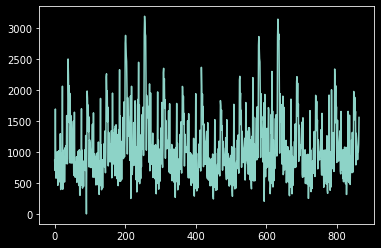

-------------------------------------------------- DAIRY --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 1.5873384176831453


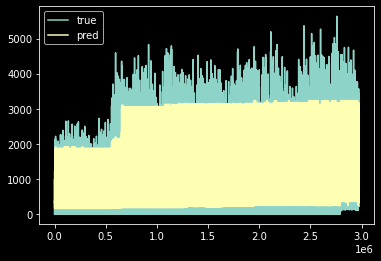

Best RMSLE in Val : 2.0
Number of feature : 1
Best number of Interation : 1000
['store_nbr']
100%|██████████| 100/100 [01:43<00:00,  1.04s/trial, best loss: 0.4525312495439658]
best_params =  {'bagging_fraction': 0.9, 'feature_fraction': 1.0, 'num_leaves': 40, 'num_round': 1300.0}
RMSLE of validation Data: 0.4525312495439658


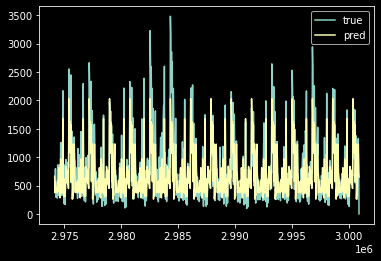

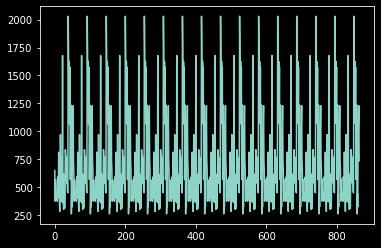

-------------------------------------------------- DELI --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.6953441324472961


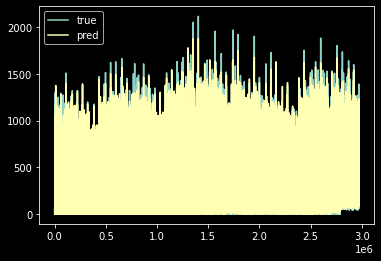

Best RMSLE in Val : 0.2435041960799691
Number of feature : 14
Best number of Interation : 1000
['store_nbr', 'day_of_year', 'avg sales', 'day_of_week', 'dcoilwtico', 'day_of_month', 'onpromotion', 'week_of_year', 'year', 'month', 'earthquake_day', 'oil_residual', 'cluster', 'oil_lags10']
100%|██████████| 100/100 [16:32<00:00,  9.92s/trial, best loss: 0.2391729090332534]
best_params =  {'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'num_leaves': 48, 'num_round': 1800.0}
RMSLE of validation Data: 0.2391729090332534


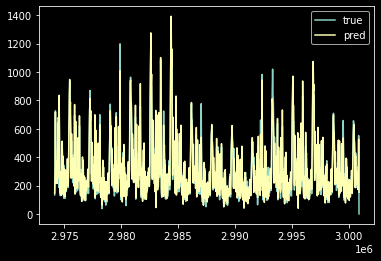

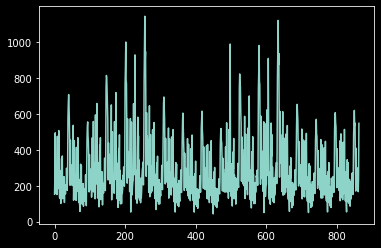

-------------------------------------------------- EGGS --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.6954758417908152


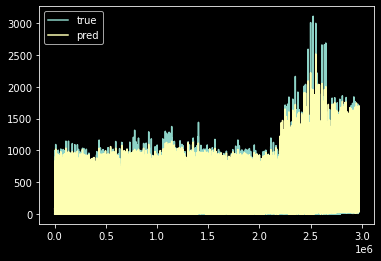

Best RMSLE in Val : 0.3589378733498931
Number of feature : 33
Best number of Interation : 955
['store_nbr', 'day_of_week', 'day_of_year', 'dcoilwtico', 'avg sales', 'onpromotion', 'day_of_month', 'oil_residual', 'week_of_year', 'year', 'earthquake_day', 'oil_seasonal', 'month', 'shopping_code', 'cluster', 'season', 'avg_oil', 'oil_lags31', 'is_year_start', 'worldcup_code', 'hoilday_code_national', 'Madre_code', 'school_season', 'oil_trend', 'week_of_month', 'is_wknd', 'is_month_end', 'is_quarter_start', 'wageday', 'oil_lags1', 'is_month_start', 'is_quarter_end', 'is_year_end']
100%|██████████| 100/100 [17:37<00:00, 10.58s/trial, best loss: 0.34879583040215917]
best_params =  {'bagging_fraction': 1.0, 'feature_fraction': 0.8, 'num_leaves': 32, 'num_round': 2000.0}
RMSLE of validation Data: 0.34879583040215917


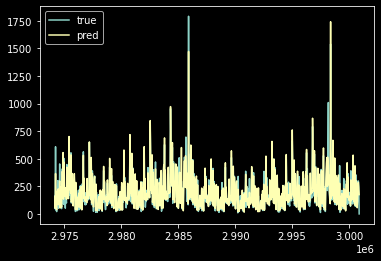

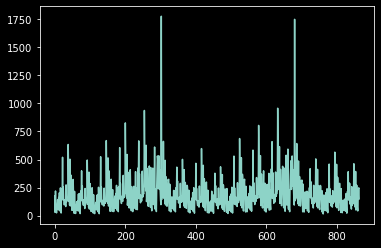

-------------------------------------------------- FROZEN FOODS --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.7786377009078331


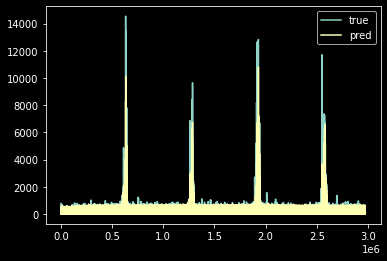

Best RMSLE in Val : 0.34092637176584006
Number of feature : 25
Best number of Interation : 993
['store_nbr', 'day_of_year', 'oil_residual', 'avg sales', 'dcoilwtico', 'day_of_month', 'day_of_week', 'oil_seasonal', 'onpromotion', 'week_of_year', 'cluster', 'oil_lags31', 'year', 'month', 'avg_oil', 'shopping_code', 'is_year_start', 'worldcup_code', 'earthquake_day', 'is_year_end', 'oil_trend', 'wageday', 'is_wknd', 'Madre_code', 'season']
100%|██████████| 100/100 [16:38<00:00,  9.98s/trial, best loss: 0.3285318478393846]
best_params =  {'bagging_fraction': 0.8, 'feature_fraction': 1.0, 'num_leaves': 50, 'num_round': 1900.0}
RMSLE of validation Data: 0.3285318478393846


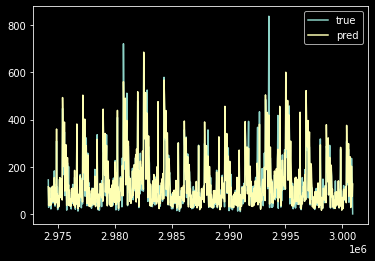

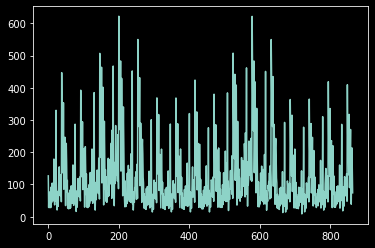

-------------------------------------------------- GROCERY I --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 1.1418996138501343


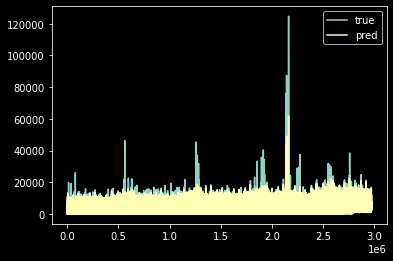

Best RMSLE in Val : 0.32097196469517386
Number of feature : 33
Best number of Interation : 884
['store_nbr', 'earthquake_day', 'onpromotion', 'day_of_year', 'day_of_week', 'avg sales', 'day_of_month', 'dcoilwtico', 'oil_residual', 'week_of_year', 'oil_seasonal', 'year', 'month', 'cluster', 'hoilday_code_national', 'oil_lags31', 'is_year_start', 'shopping_code', 'avg_oil', 'season', 'school_season', 'is_month_end', 'oil_trend', 'week_of_month', 'is_wknd', 'is_quarter_start', 'wageday', 'worldcup_code', 'Madre_code', 'is_year_end', 'is_month_start', 'oil_lags1', 'is_quarter_end']
100%|██████████| 100/100 [18:03<00:00, 10.83s/trial, best loss: 0.3177389277415247]
best_params =  {'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'num_leaves': 40, 'num_round': 1400.0}
RMSLE of validation Data: 0.3177389277415247


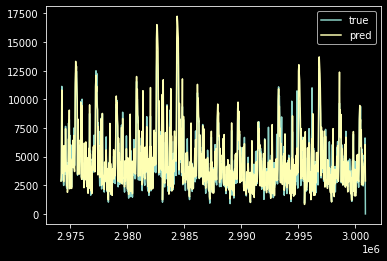

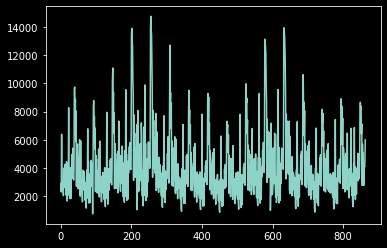

-------------------------------------------------- GROCERY II --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.8721144588253328


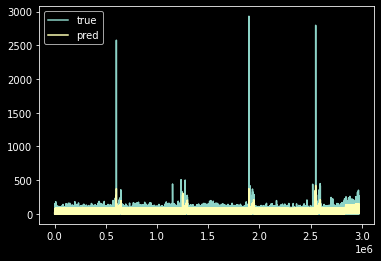

Best RMSLE in Val : 2.0
Number of feature : 1
Best number of Interation : 1000
['store_nbr']
100%|██████████| 100/100 [01:23<00:00,  1.20trial/s, best loss: 0.706243105310642]
best_params =  {'bagging_fraction': 1.0, 'feature_fraction': 0.8, 'num_leaves': 42, 'num_round': 1600.0}
RMSLE of validation Data: 0.706243105310642


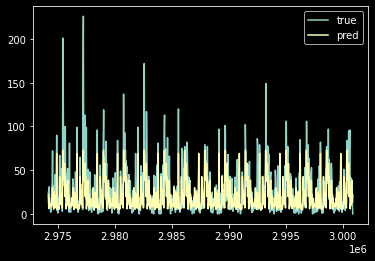

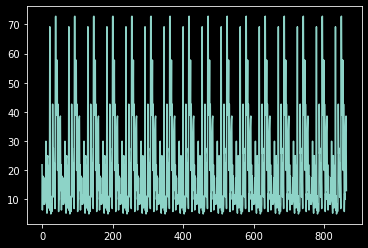

-------------------------------------------------- HARDWARE --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.5308716462778993


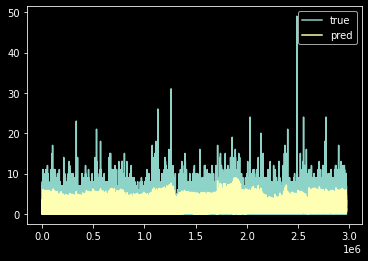

Best RMSLE in Val : 0.5490869475138109
Number of feature : 21
Best number of Interation : 545
['store_nbr', 'day_of_year', 'dcoilwtico', 'day_of_week', 'avg sales', 'year', 'week_of_year', 'day_of_month', 'oil_residual', 'earthquake_day', 'shopping_code', 'is_year_start', 'oil_lags31', 'onpromotion', 'cluster', 'month', 'worldcup_code', 'avg_oil', 'Madre_code', 'oil_seasonal', 'hoilday_code_national']
100%|██████████| 100/100 [05:45<00:00,  3.46s/trial, best loss: 0.5483994854350502]
best_params =  {'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'num_leaves': 44, 'num_round': 1500.0}
RMSLE of validation Data: 0.5483994854350502


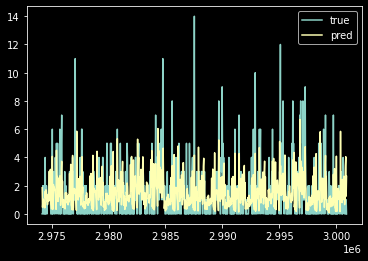

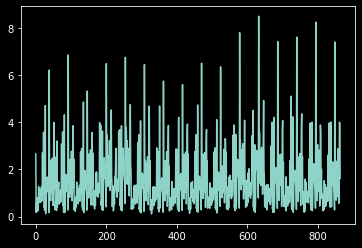

-------------------------------------------------- HOME AND KITCHEN I --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.8429381476422723


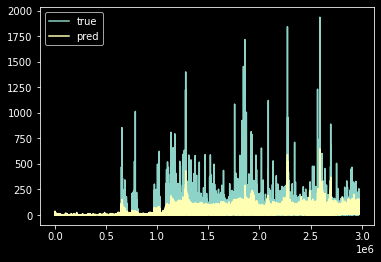

Best RMSLE in Val : 2.0
Number of feature : 1
Best number of Interation : 1000
['store_nbr']
100%|██████████| 100/100 [01:20<00:00,  1.25trial/s, best loss: 0.6489532224558517]
best_params =  {'bagging_fraction': 1.0, 'feature_fraction': 1.0, 'num_leaves': 48, 'num_round': 1500.0}
RMSLE of validation Data: 0.6489532224558517


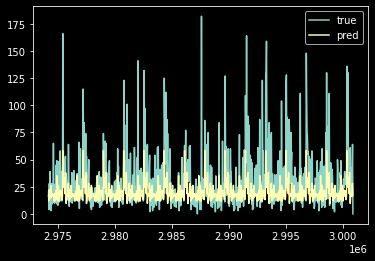

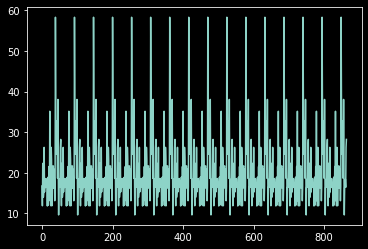

-------------------------------------------------- HOME AND KITCHEN II --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.7254045758302476


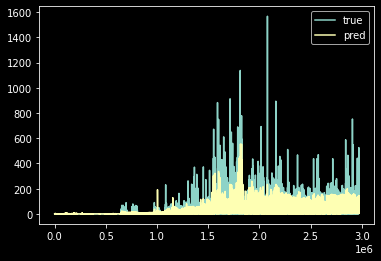

Best RMSLE in Val : 0.4961286378995099
Number of feature : 23
Best number of Interation : 215
['store_nbr', 'dcoilwtico', 'day_of_year', 'avg sales', 'onpromotion', 'day_of_week', 'day_of_month', 'year', 'earthquake_day', 'week_of_year', 'oil_residual', 'month', 'season', 'oil_lags31', 'oil_seasonal', 'avg_oil', 'school_season', 'cluster', 'hoilday_code_national', 'worldcup_code', 'is_year_start', 'Madre_code', 'shopping_code']
100%|██████████| 100/100 [03:30<00:00,  2.11s/trial, best loss: 0.49034113694679854]
best_params =  {'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'num_leaves': 32, 'num_round': 300.0}
RMSLE of validation Data: 0.49034113694679854


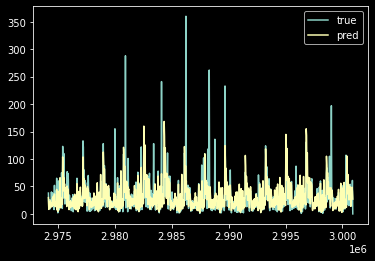

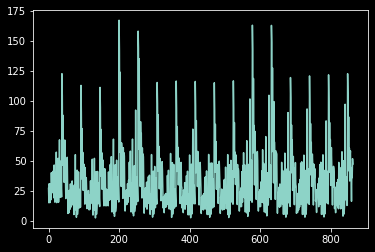

-------------------------------------------------- HOME APPLIANCES --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.4001440497349244


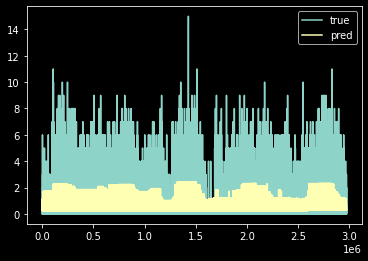

Best RMSLE in Val : 2.0
Number of feature : 1
Best number of Interation : 1000
['dcoilwtico']
100%|██████████| 100/100 [06:29<00:00,  3.89s/trial, best loss: 0.38770172047953255]
best_params =  {'bagging_fraction': 0.8, 'feature_fraction': 1.0, 'num_leaves': 46, 'num_round': 1700.0}
RMSLE of validation Data: 0.38770172047953255


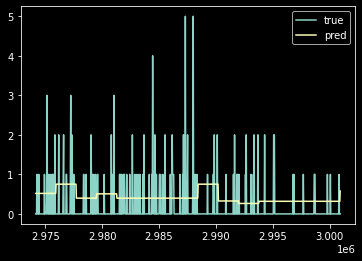

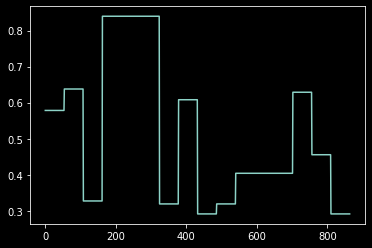

-------------------------------------------------- HOME CARE --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 2.028473540918479


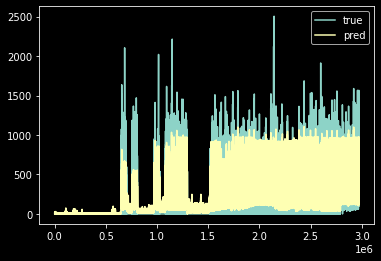

Best RMSLE in Val : 0.2667639749524012
Number of feature : 27
Best number of Interation : 986
['store_nbr', 'day_of_week', 'month', 'dcoilwtico', 'year', 'day_of_month', 'avg sales', 'day_of_year', 'onpromotion', 'week_of_year', 'earthquake_day', 'avg_oil', 'oil_lags31', 'school_season', 'worldcup_code', 'is_year_start', 'oil_trend', 'shopping_code', 'season', 'hoilday_code_national', 'cluster', 'week_of_month', 'is_month_start', 'oil_lags1', 'is_wknd', 'quarter', 'is_quarter_start']
100%|██████████| 100/100 [16:40<00:00, 10.00s/trial, best loss: 0.26383413051376525]
best_params =  {'bagging_fraction': 1.0, 'feature_fraction': 1.0, 'num_leaves': 42, 'num_round': 1600.0}
RMSLE of validation Data: 0.26383413051376525


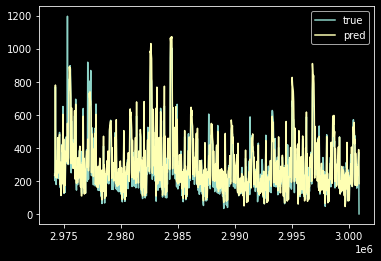

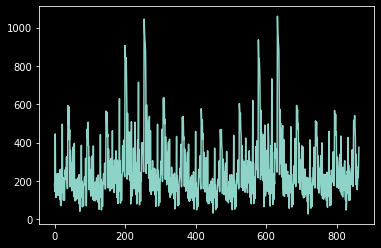

-------------------------------------------------- LADIESWEAR --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.8970535851864418


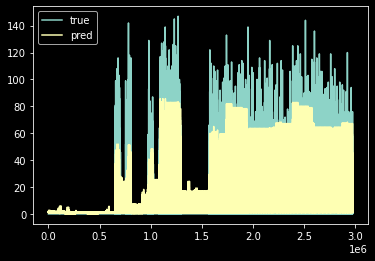

Best RMSLE in Val : 0.5563757597251663
Number of feature : 6
Best number of Interation : 726
['store_nbr', 'year', 'day_of_week', 'month', 'dcoilwtico', 'day_of_year']
100%|██████████| 100/100 [07:19<00:00,  4.40s/trial, best loss: 0.5309067426152022]
best_params =  {'bagging_fraction': 0.9, 'feature_fraction': 0.8, 'num_leaves': 40, 'num_round': 1200.0}
RMSLE of validation Data: 0.5309067426152022


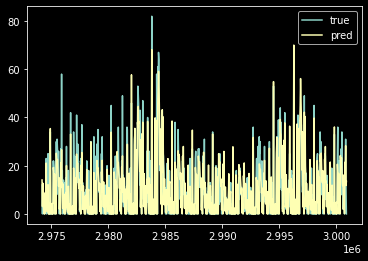

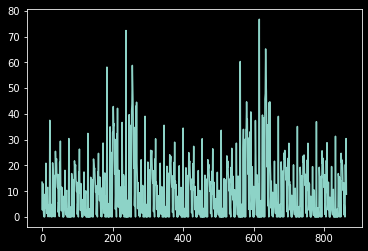

-------------------------------------------------- LAWN AND GARDEN --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.7219398777590799


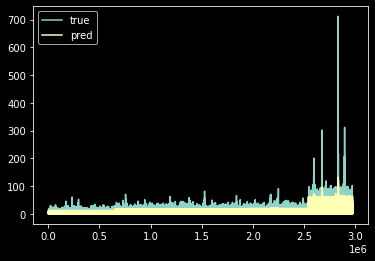

Best RMSLE in Val : 0.4570244350009524
Number of feature : 9
Best number of Interation : 327
['store_nbr', 'day_of_week', 'day_of_year', 'avg sales', 'shopping_code', 'onpromotion', 'year', 'dcoilwtico', 'cluster']
100%|██████████| 100/100 [03:15<00:00,  1.96s/trial, best loss: 0.4546047575796527]
best_params =  {'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'num_leaves': 44, 'num_round': 600.0}
RMSLE of validation Data: 0.4546047575796527


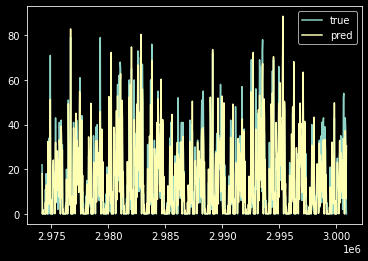

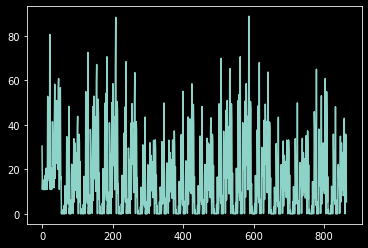

-------------------------------------------------- LINGERIE --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.8157234964717602


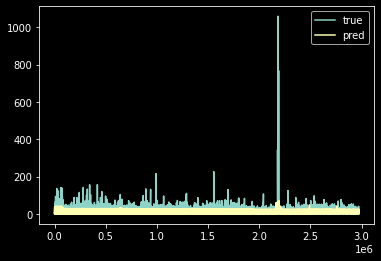

Best RMSLE in Val : 2.0
Number of feature : 1
Best number of Interation : 1000
['store_nbr']
100%|██████████| 100/100 [02:00<00:00,  1.21s/trial, best loss: 0.8033345213578406]
best_params =  {'bagging_fraction': 0.9, 'feature_fraction': 1.0, 'num_leaves': 36, 'num_round': 1200.0}
RMSLE of validation Data: 0.8033345213578406


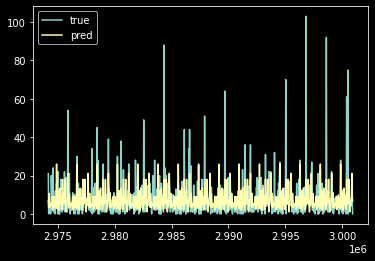

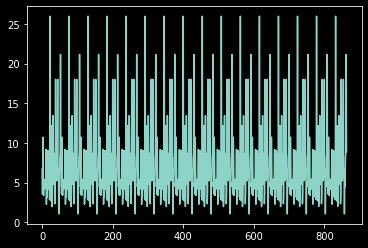

-------------------------------------------------- LIQUOR,WINE,BEER --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 1.0308375757624015


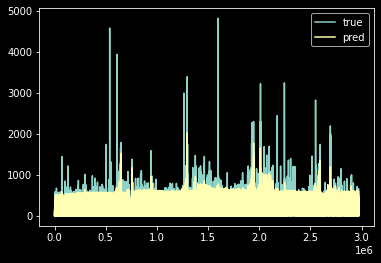

Best RMSLE in Val : 0.49650024795161224
Number of feature : 27
Best number of Interation : 520
['store_nbr', 'day_of_year', 'day_of_week', 'dcoilwtico', 'avg sales', 'day_of_month', 'week_of_year', 'onpromotion', 'oil_residual', 'earthquake_day', 'year', 'month', 'oil_seasonal', 'oil_lags31', 'cluster', 'avg_oil', 'shopping_code', 'is_year_end', 'oil_trend', 'hoilday_code_national', 'is_year_start', 'worldcup_code', 'is_wknd', 'is_quarter_start', 'Madre_code', 'season', 'school_season']
100%|██████████| 100/100 [07:50<00:00,  4.70s/trial, best loss: 0.49650024795161224]
best_params =  {'bagging_fraction': 0.8, 'feature_fraction': 0.9, 'num_leaves': 30, 'num_round': 900.0}
RMSLE of validation Data: 0.49650024795161224


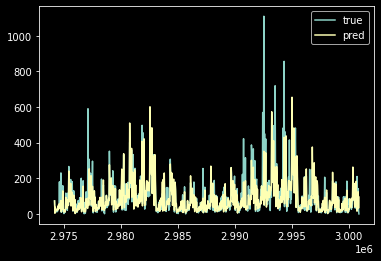

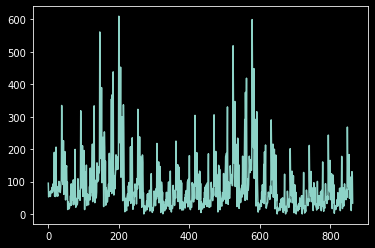

-------------------------------------------------- MAGAZINES --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.3921091816825393


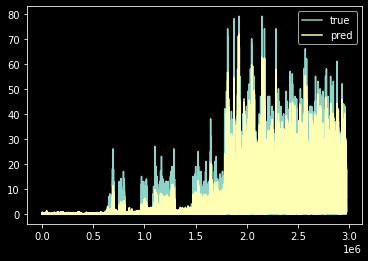

Best RMSLE in Val : 0.5135110264349941
Number of feature : 14
Best number of Interation : 679
['store_nbr', 'day_of_year', 'dcoilwtico', 'day_of_month', 'avg sales', 'oil_residual', 'day_of_week', 'earthquake_day', 'oil_seasonal', 'week_of_year', 'year', 'oil_lags31', 'month', 'avg_oil']
100%|██████████| 100/100 [07:30<00:00,  4.50s/trial, best loss: 0.5003386158628258]
best_params =  {'bagging_fraction': 1.0, 'feature_fraction': 0.9, 'num_leaves': 50, 'num_round': 1500.0}
RMSLE of validation Data: 0.5003386158628258


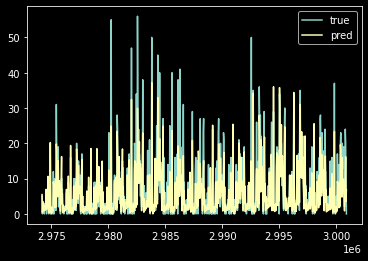

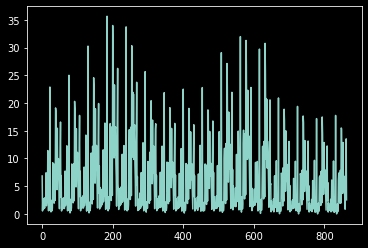

-------------------------------------------------- MEATS --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 1.3138552269708335


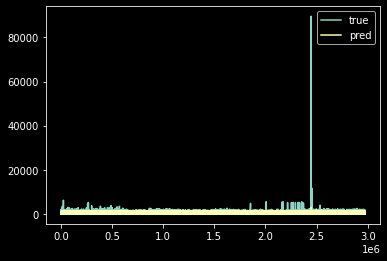

Best RMSLE in Val : 2.0
Number of feature : 1
Best number of Interation : 1000
['store_nbr']
100%|██████████| 100/100 [01:48<00:00,  1.08s/trial, best loss: 0.49359071443719976]
best_params =  {'bagging_fraction': 0.9, 'feature_fraction': 0.8, 'num_leaves': 44, 'num_round': 1400.0}
RMSLE of validation Data: 0.49359071443719976


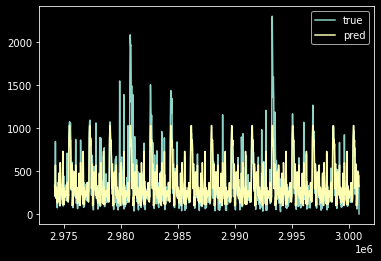

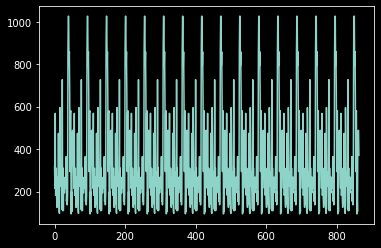

-------------------------------------------------- PERSONAL CARE --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.7595963320746915


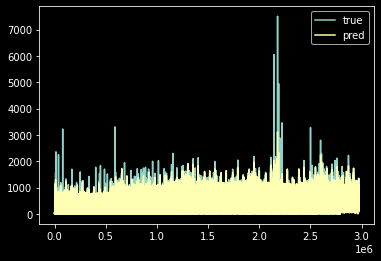

Best RMSLE in Val : 0.2808210825188764
Number of feature : 24
Best number of Interation : 835
['store_nbr', 'onpromotion', 'day_of_week', 'day_of_year', 'avg sales', 'day_of_month', 'earthquake_day', 'dcoilwtico', 'week_of_year', 'oil_residual', 'year', 'oil_seasonal', 'month', 'oil_lags31', 'oil_trend', 'cluster', 'is_year_start', 'worldcup_code', 'hoilday_code_national', 'avg_oil', 'shopping_code', 'season', 'is_month_end', 'school_season']
100%|██████████| 100/100 [13:44<00:00,  8.25s/trial, best loss: 0.2781612917618959]
best_params =  {'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'num_leaves': 46, 'num_round': 1600.0}
RMSLE of validation Data: 0.2781612917618959


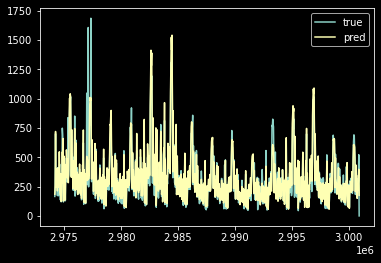

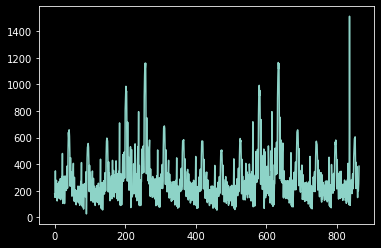

-------------------------------------------------- PET SUPPLIES --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.422595655393721


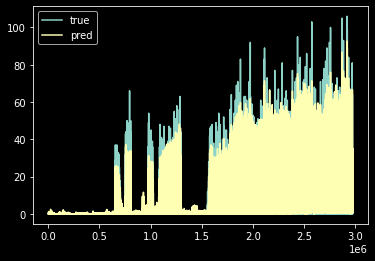

Best RMSLE in Val : 0.490227277886354
Number of feature : 21
Best number of Interation : 244
['store_nbr', 'dcoilwtico', 'avg sales', 'day_of_year', 'day_of_week', 'day_of_month', 'year', 'month', 'oil_residual', 'week_of_year', 'worldcup_code', 'school_season', 'onpromotion', 'oil_lags31', 'oil_seasonal', 'earthquake_day', 'shopping_code', 'oil_trend', 'avg_oil', 'hoilday_code_national', 'season']
100%|██████████| 100/100 [03:27<00:00,  2.07s/trial, best loss: 0.4865516176848428]
best_params =  {'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'num_leaves': 40, 'num_round': 900.0}
RMSLE of validation Data: 0.4865516176848428


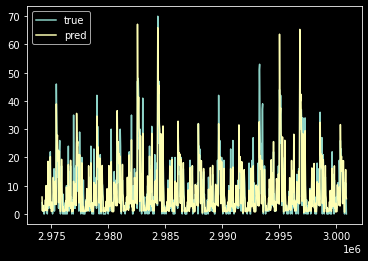

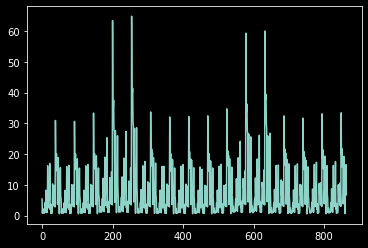

-------------------------------------------------- PLAYERS AND ELECTRONICS --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.4819181464099187


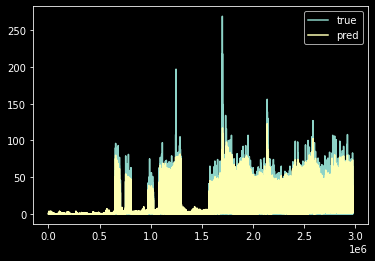

Best RMSLE in Val : 0.48636067723943693
Number of feature : 27
Best number of Interation : 987
['store_nbr', 'day_of_year', 'dcoilwtico', 'avg sales', 'day_of_month', 'day_of_week', 'year', 'month', 'week_of_year', 'earthquake_day', 'oil_residual', 'oil_seasonal', 'worldcup_code', 'oil_lags31', 'shopping_code', 'onpromotion', 'school_season', 'oil_trend', 'avg_oil', 'cluster', 'hoilday_code_national', 'Madre_code', 'season', 'is_year_start', 'is_wknd', 'is_month_end', 'is_quarter_start']
100%|██████████| 100/100 [11:51<00:00,  7.12s/trial, best loss: 0.4838940653014507]
best_params =  {'bagging_fraction': 0.8, 'feature_fraction': 1.0, 'num_leaves': 40, 'num_round': 2000.0}
RMSLE of validation Data: 0.4838940653014507


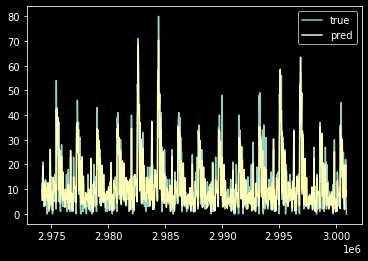

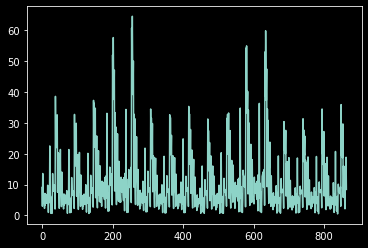

-------------------------------------------------- POULTRY --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 1.4397700740013488


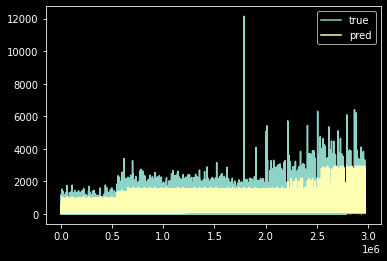

Best RMSLE in Val : 2.0
Number of feature : 1
Best number of Interation : 1000
['avg sales']
100%|██████████| 100/100 [01:53<00:00,  1.14s/trial, best loss: 0.49580707006796515]
best_params =  {'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'num_leaves': 32, 'num_round': 1300.0}
RMSLE of validation Data: 0.49580707006796515


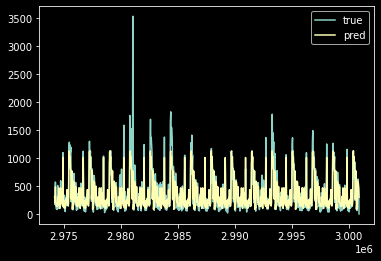

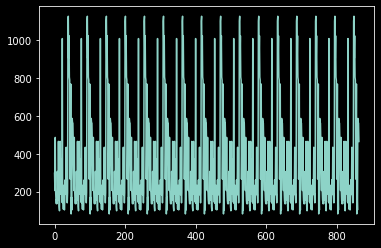

-------------------------------------------------- PREPARED FOODS --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.5387135577813235


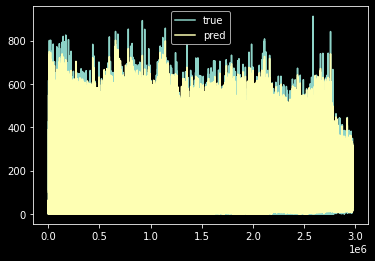

Best RMSLE in Val : 0.323937738947925
Number of feature : 19
Best number of Interation : 1000
['store_nbr', 'day_of_year', 'avg sales', 'dcoilwtico', 'day_of_week', 'day_of_month', 'oil_residual', 'week_of_year', 'year', 'onpromotion', 'oil_seasonal', 'earthquake_day', 'month', 'cluster', 'oil_lags31', 'oil_trend', 'shopping_code', 'avg_oil', 'Madre_code']
100%|██████████| 100/100 [20:42<00:00, 12.43s/trial, best loss: 0.30979195288086925]
best_params =  {'bagging_fraction': 1.0, 'feature_fraction': 1.0, 'num_leaves': 34, 'num_round': 2000.0}
RMSLE of validation Data: 0.30979195288086925


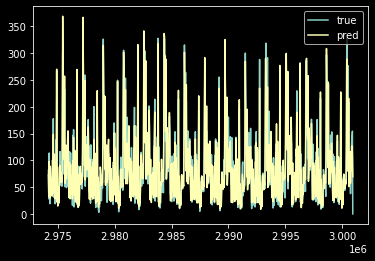

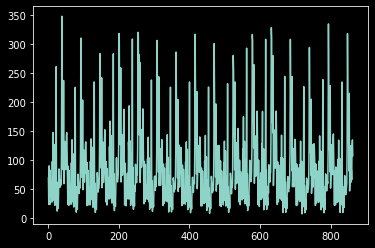

-------------------------------------------------- PRODUCE --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 1.8037132584894928


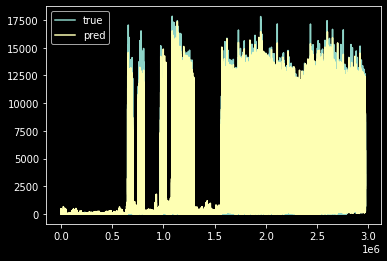

Best RMSLE in Val : 0.3338912436489521
Number of feature : 30
Best number of Interation : 773
['store_nbr', 'avg sales', 'dcoilwtico', 'day_of_year', 'day_of_week', 'onpromotion', 'day_of_month', 'year', 'month', 'week_of_year', 'worldcup_code', 'oil_lags31', 'oil_residual', 'earthquake_day', 'oil_trend', 'season', 'avg_oil', 'cluster', 'school_season', 'oil_seasonal', 'hoilday_code_national', 'is_year_start', 'shopping_code', 'Madre_code', 'week_of_month', 'is_wknd', 'is_month_end', 'wageday', 'is_quarter_start', 'oil_lags1']
100%|██████████| 100/100 [15:59<00:00,  9.60s/trial, best loss: 0.32927836445279035]
best_params =  {'bagging_fraction': 1.0, 'feature_fraction': 0.8, 'num_leaves': 40, 'num_round': 1700.0}
RMSLE of validation Data: 0.32927836445279035


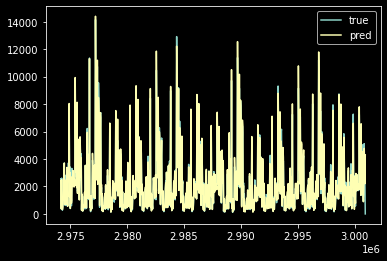

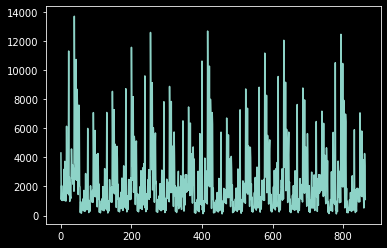

-------------------------------------------------- SCHOOL AND OFFICE SUPPLIES --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.5125946201609882


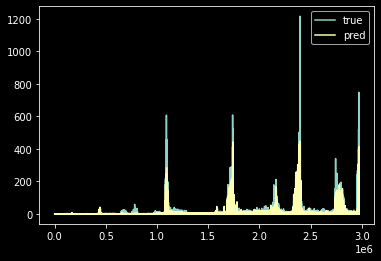

Best RMSLE in Val : 0.7307572101112582
Number of feature : 2
Best number of Interation : 270
['onpromotion', 'day_of_year']
100%|██████████| 100/100 [02:21<00:00,  1.42s/trial, best loss: 0.7203682115166663]
best_params =  {'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'num_leaves': 50, 'num_round': 1200.0}
RMSLE of validation Data: 0.7203682115166663


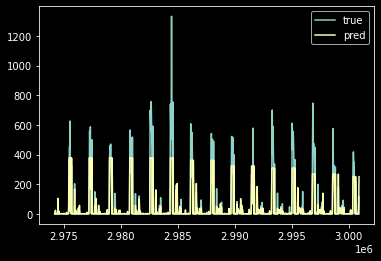

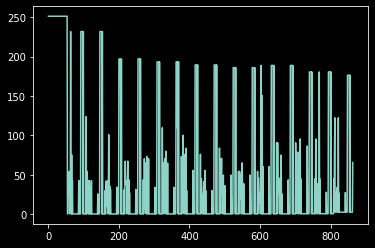

-------------------------------------------------- SEAFOOD --------------------------------------------------
(90127, 38) (90127, 1)
(811, 38) (811, 1)
(864, 38)
RMSLE of train Data: 0.5596964412838452


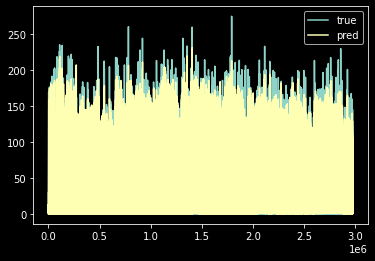

Best RMSLE in Val : 0.5200316954042845
Number of feature : 13
Best number of Interation : 575
['store_nbr', 'dcoilwtico', 'day_of_year', 'avg sales', 'day_of_week', 'day_of_month', 'oil_residual', 'week_of_year', 'year', 'onpromotion', 'month', 'oil_seasonal', 'avg_oil']
100%|██████████| 100/100 [07:51<00:00,  4.71s/trial, best loss: 0.515702946362462]
best_params =  {'bagging_fraction': 0.8, 'feature_fraction': 0.9, 'num_leaves': 42, 'num_round': 1200.0}
RMSLE of validation Data: 0.515702946362462


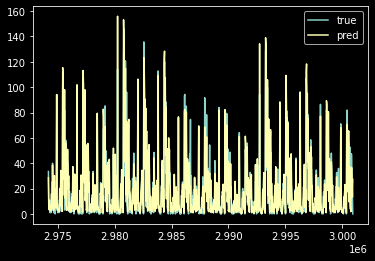

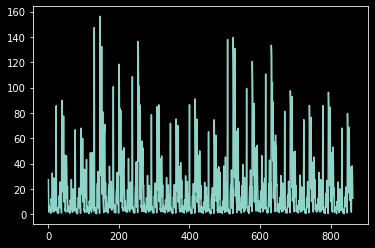

In [16]:
df_sub = pd.read_csv(path + 'sample_submission.csv', index_col='id')

for item in df_all['family'].unique():
    print('--------------------------------------------------', item, '--------------------------------------------------')
    X = df_all[df_all['family']==item]
    Y = df_all[df_all['family']==item]

    # Spilt Dataset
    train_sdate = '2013-01-01'
    val_sdate = '2017-08-01'
    test_sdate = '2017-08-16'
    train_split = X[X['date']== train_sdate].index[0]
    val_split = X[X['date']== val_sdate].index[0]
    test_split = X[X['date']== test_sdate].index[0]

    # Specify categorical feature
    X[['store_nbr', 'cluster']] = X[['store_nbr', 'cluster']].astype('category')

    X_Train = X.loc[train_split:val_split].drop(['date', 'family', 'sales', 'id', 'city', 'state', 'type'], axis=1)
    Y_Train = Y[['sales']].loc[train_split:val_split]
    X_Val = X.loc[val_split:test_split].drop(['date', 'family', 'sales', 'id', 'city', 'state', 'type'], axis=1)
    Y_Val = Y[['sales']].loc[val_split:test_split]
    X_Test = X.loc[test_split:].drop(['date', 'family', 'sales', 'id', 'city', 'state', 'type'], axis=1)
    X_Test_id = X.loc[test_split:]['id']

    print(X_Train.shape, Y_Train.shape)
    print(X_Val.shape, Y_Val.shape)
    print(X_Test.shape)

    # Create Dataset
    lgb_train = lgb.Dataset(X_Train, Y_Train, free_raw_data=False)
    lgb_val = lgb.Dataset(X_Val,Y_Val, free_raw_data=False)
    num_round = 1000

    # Customize metirc function
    def RMSLE(pred, train_data):
        labels = train_data.get_label()
        preds = pred
        if type(preds) is not int:
            preds[preds < 0] = 0
        return 'rmsle', np.sqrt(mean_squared_log_error(labels, preds)), False

    # Training
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',  
        'objective': 'regression',  
        'learning_rate': 0.05,  
        'bagging_freq': 5,  
        'verbose': -1,  
        'random_state': 1,
        'early_stopping_round': int(num_round/10),

        'num_leaves': 20,  
        'bagging_fraction': 0.8,  
        'feature_fraction': 0.9,  
    }   

    gbm = lgb.train(params, lgb_train, num_boost_round = num_round, valid_sets=lgb_val, verbose_eval=False, feval=RMSLE)

    # Training accuracy
    train_pred = gbm.predict(X_Train, num_iteration=gbm.best_iteration)
    train_pred[train_pred < 0] = 0
    train_rmse = mean_squared_log_error(Y_Train, train_pred)
    print('RMSLE of train Data:', np.sqrt(train_rmse))

    train_pred = pd.Series(train_pred, index = Y_Train.index)
    plt.plot(Y_Train, label = 'true')
    plt.plot(train_pred, label = 'pred')
    plt.legend()
    plt.show()
    plt.close()

    # Feature Importances
    importances = gbm.feature_importance()
    indices = np.argsort(importances)[::-1]
    feat_labels = X_Train.columns[:]

    # Feature Selection
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',  
        'objective': 'regression',  
        'learning_rate': 0.05,  
        'bagging_freq': 5,  
        'verbose': -1,  
        'random_state': 1,
        'early_stopping_round': int(num_round/10),

        'num_leaves': 30,  
        'bagging_fraction': 0.8,  
        'feature_fraction': 0.9,  
    }
    
    Patience =  X.shape[0]//2 # Early stop condition
    Best_rmsle = 4
    Num_feature = 1
    Best_interation = num_round
    Best_feature = []
    for t in range(Num_feature, X_Train.shape[1]):
        
        # Creat selected feature list
        select_feature = []
        for i in range(t):
            select_feature.append(feat_labels[indices[i]])
        
        X_Tr = X_Train[select_feature]
        X_Vl = X_Val[select_feature]

        # Training
        lgb_train = lgb.Dataset(X_Tr, Y_Train)
        lgb_val = lgb.Dataset(X_Vl,Y_Val)
        gbm = lgb.train(params, lgb_train, num_boost_round = num_round, valid_sets=lgb_val, verbose_eval=False, feval=RMSLE)

        # Prediction
        val_pred = gbm.predict(X_Vl, num_iteration=gbm.best_iteration)
        val_pred[val_pred < 0] = 0

        # Calculate the error and record the best setting
        Val_rmsle = mean_squared_log_error(Y_Val, val_pred)
        if Val_rmsle < Best_rmsle and gbm.best_iteration > 200: 
            Best_rmsle = Val_rmsle
            Num_feature = t
            Best_feature = select_feature
            Best_interation = gbm.best_iteration
            Patience = X.shape[0]//4
        else:
            Patience = Patience - 1
        
        # print(t, Patience, '|' ,gbm.best_iteration, '/' ,Best_interation, '|' , np.sqrt(Val_rmsle), '/' ,np.sqrt(Best_rmsle))
        
        # Early stop
        if Patience == 0:
            break

    print('Best RMSLE in Val :', np.sqrt(Best_rmsle))
    print('Number of feature :', Num_feature)
    print('Best number of Interation :', Best_interation)

    Best_feature = [] 
    for i in range(Num_feature):  
        Best_feature.append(feat_labels[indices[i]])

    X_Train = X_Train[Best_feature]
    X_Val = X_Val[Best_feature]
    X_Test = X_Test[Best_feature]

    lgb_train = lgb.Dataset(X_Train, Y_Train)
    lgb_val = lgb.Dataset(X_Val,Y_Val)

    print(Best_feature)

    # Paramert Tuning
    param_space = {
        'num_leaves': hp.choice('num_leaves', [30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]),
        'bagging_fraction': hp.choice('bagging_fraction', [0.8, 0.9, 1.0]),
        'feature_fraction': hp.choice('feature_fraction', [0.8, 0.9, 1.0]),
        'num_round': hp.quniform('num_round', Best_interation, Best_interation+1000, 100)
    }

    def gbm_tuning(parameters):
        params = {
                'task': 'train',
                'boosting_type': 'gbdt',  
                'objective': 'regression',   
                'learning_rate': 0.05,  
                'bagging_freq': 5,  
                'verbose': -1,  
                'random_state': 1,
                'early_stopping_round': int(parameters['num_round']/10),

                'num_leaves': parameters['num_leaves'],  
                'bagging_fraction': parameters['bagging_fraction'],  
                'feature_fraction': parameters['feature_fraction'],  
            }

        gbm = lgb.train(params, lgb_train, num_boost_round = int(parameters['num_round']), valid_sets=lgb_val, verbose_eval=False, feval=RMSLE)

        val_pred = gbm.predict(X_Val, num_iteration=gbm.best_iteration)
        val_pred[val_pred < 0] = 0
        val_rmse = mean_squared_log_error(Y_Val, val_pred)

        return np.sqrt(val_rmse)

    best = fmin(fn=gbm_tuning, space = param_space, algo=tpe.suggest, max_evals=100)
    best_params = space_eval(param_space ,best)
    print("best_params = ", best_params)

    params = {
        'task': 'train',
        'boosting_type': 'gbdt',  
        'objective': 'regression',  
        'learning_rate': 0.05,  
        'bagging_freq': 5,  
        'verbose': -1,  
        'random_state': 1,
        'early_stopping_round': int(best_params['num_round']/10),

        'num_leaves': best_params['num_leaves'],  
        'bagging_fraction': best_params['bagging_fraction'],  
        'feature_fraction': best_params['feature_fraction'],  
    }

    gbm = lgb.train(params, lgb_train, num_boost_round= int(best_params['num_round']), valid_sets=lgb_val, verbose_eval=False, feval=RMSLE)

    # Validation accuracy
    val_pred = gbm.predict(X_Val, num_iteration=gbm.best_iteration)
    val_pred[val_pred < 0] = 0
    val_rmse = mean_squared_log_error(Y_Val, val_pred)
    print('RMSLE of validation Data:', np.sqrt(val_rmse))
    
    val_pred = pd.Series(val_pred, index = Y_Val.index)
    plt.plot(Y_Val, label = 'true' )
    plt.plot(val_pred, label = 'pred')
    plt.legend()
    plt.show()
    plt.close()

    # Prediction
    test_pred = gbm.predict(X_Test, num_iteration=gbm.best_iteration)
    test_pred[test_pred < 0] = 0
    plt.plot(test_pred)
    plt.show()
    plt.close()
    
    # Save Result
    test_pred = pd.Series(test_pred)
    df_result = pd.DataFrame()
    df_result[0] = X_Test_id
    df_result[1] = test_pred.values
    df_sub.loc[df_result[0]] = df_result[1].values.reshape(-1,1)

# Zero Forecasting
df_famil_0 = df_all.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
df_famil_0 = df_famil_0[df_famil_0.sales == 0]
for i in range(df_famil_0.shape[0]):
      id = df_test[df_test['store_nbr'] == df_famil_0['store_nbr'].iloc[i]]
      id = id[id['family'] == df_famil_0['family'].iloc[i]]
      df_sub.loc[id['id']] = 0

df_sub.to_csv('submission.csv', index=True)